# Week 11 Practice

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
import yfinance as yf
import os

## Download the real data

We’re going to complete this post by optimising portfolio weights for a basket of five assets:

In [2]:
Data = yf.download("AAPL AMZN BABA GOOG MSFT", start="2019-11-27", end="2020-11-28")

[*********************100%***********************]  5 of 5 completed


Next we can calculate the daily average returns for each asset in the dataset by doing the following

In [3]:
returns = np.log(Data['Adj Close']/Data['Adj Close'].shift(1))
returns.describe()

,AAPL,AMZN,BABA,GOOG,MSFT
count,252.000000,252.000000,252.000000,252.000000,252.000000
mean,0.002267,0.002237,0.001269,0.001237,0.001414
std,0.029170,0.024195,0.024001,0.024133,0.027672
min,-0.137708,-0.082535,-0.086182,-0.117667,-0.159453
25%,-0.010488,-0.010544,-0.011592,-0.006602,-0.010557
50%,0.002111,0.002805,0.001066,0.003185,0.002788
75%,0.016618,0.014362,0.014461,0.013502,0.012661
max,0.113158,0.076308,0.085728,0.089856,0.132929


By plotting the normalised adjusted closes we can see the relative performance of each asset. The ideal portfolio will benefit from assets that tend to covary in opposing ways.

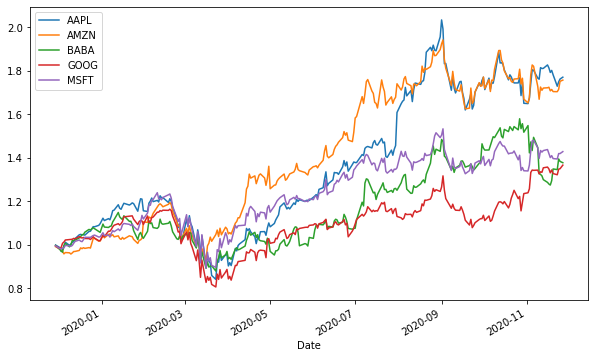

In [4]:
returns.cumsum().apply(np.exp).plot(figsize=(10, 6));

To get the average annualised returns we multiple by 252 trading days

In [5]:
returns.mean() * 252

AAPL    0.571321
AMZN    0.563676
BABA    0.319730
GOOG    0.311689
MSFT    0.356262
dtype: float64

In [6]:
returns.cov()

,AAPL,AMZN,BABA,GOOG,MSFT
AAPL,0.000851,0.000499,0.000403,0.000539,0.000688
AMZN,0.000499,0.000585,0.000311,0.000400,0.000495
BABA,0.000403,0.000311,0.000576,0.000324,0.000406
GOOG,0.000539,0.000400,0.000324,0.000582,0.000575
MSFT,0.000688,0.000495,0.000406,0.000575,0.000766


Likewise, we can get the annualised covariance matrix for these 5 assets accordingly

In [7]:
returns.cov() * 252

,AAPL,AMZN,BABA,GOOG,MSFT
AAPL,0.214429,0.125668,0.101619,0.135892,0.173473
AMZN,0.125668,0.147519,0.078489,0.100794,0.124671
BABA,0.101619,0.078489,0.145159,0.081586,0.102211
GOOG,0.135892,0.100794,0.081586,0.146767,0.144935
MSFT,0.173473,0.124671,0.102211,0.144935,0.192969


The following single line of code generates a random array of weights that sum to 1.0. In the portfolio, one of the assumptions is that all funds will deployed to the assets in the portfolio according to some weighting.

In [8]:
weights = np.random.dirichlet(np.ones(5), size=1)
weights = weights[0]
print(weights)

[0.103397   0.02267053 0.19732819 0.61148849 0.06511579]


From these weights, we can calculate the expected weighted return of the portfolio of assets using these random weights.

In [9]:
exp_port_return = np.sum(returns.mean()*weights)*252
print(exp_port_return)

0.34873593783446494


The next thing we do is calculate the portfolio variance by way of the following. Here we’re using np.dot to take the dot product of the three arguments. Weights is transposed into a column matrix from a row matrix. It might look fancy and confusing, but without transposing the weights we would end up multiplying all variances by all weights, which isn’t what we want.

In [10]:
port_var = np.dot(weights.T, np.dot(returns.cov()*252, weights))
port_vol = np.sqrt(port_var)
print(port_var)
print(port_vol)

0.1256954547999002
0.35453554800597953


## The Portfolio Simulation Function

In [11]:
def portfolio_simulation(data, n, iterations):
    '''
    Runs a simulation by randomly selecting portfolio weights a specified
    number of times (iterations), returns the list of results and plots 
    all the portfolios as well.
    
    Parameters:
    -----------  
        assets: list
            all the assets that are to be pulled from Quandl to comprise
            our portfolio.    
        iterations: int 
            the number of randomly generated portfolios to build.
    
    Returns:
    --------
        port_returns: array
            array of all the simulated portfolio returns.
        port_vols: array
            array of all the simulated portfolio volatilities.
    '''
    
    # Fetch data    
    returns = np.log(Data['Adj Close']/Data['Adj Close'].shift(1))
    
    port_returns = []
    port_vols = []
    
    for i in range (iterations):
        weights = np.random.dirichlet(np.ones(n), size=1)
        weights = weights[0]
        port_returns.append(np.sum(returns.mean() * weights) * 252)
        port_vols.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights))))
    
    # Convert lists to arrays
    port_returns = np.array(port_returns)
    port_vols = np.array(port_vols)
 
    
    # Plot the distribution of portfolio returns and volatilities 
    plt.figure(figsize = (10,6))
    plt.scatter(port_vols,port_returns,c = (port_returns / port_vols), marker='o')
    plt.xlabel('Portfolio Volatility')
    plt.ylabel('Portfolio Return')
    plt.colorbar(label = 'Sharpe ratio (not adjusted for short rate)')
    
    return port_returns, port_vols

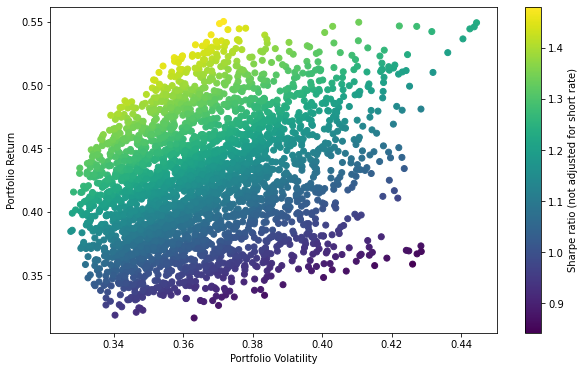

In [12]:
port_returns, port_vols = portfolio_simulation(Data, 5, 3000)

The resulting plot above is called the Markowitz Bullet. You might have noticed that the sprawl of dots - each representing one portfolio in the simulation - starts to form a sideways parabola. This shape lends itself extremely well to quadratic optimization functions because there is only one truly global minima and no other “false minima” that the optimization algorithm might get “stuck in”.

## Global Minimum Variance Portfolio

In [13]:
port_vols.min()

0.32767593122913796

In [14]:
idx1 = np.argmin(port_vols)
port_returns[idx1]

0.3845775211034956

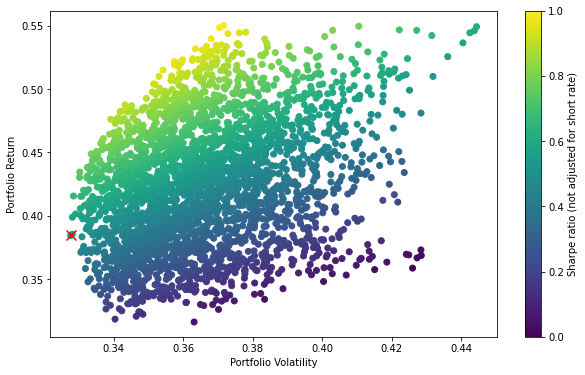

In [15]:
plt.figure(figsize = (10,6))
plt.scatter(port_vols,port_returns,c = (port_returns / port_vols), marker='o')
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.scatter(port_vols.min(), port_returns[idx1], c='red', marker = 'x', s=100) # red cross
plt.colorbar(label = 'Sharpe ratio (not adjusted for short rate)')

## Maximum Sharpe Ratio Portfolio

In [16]:
r = 0.01
Sharpe_ratio = (port_returns - r) / port_vols
idx2 = np.argmax(Sharpe_ratio)
port_returns[idx2]

0.5485439503145584

In [17]:
port_vols[idx2]

0.370467504665973

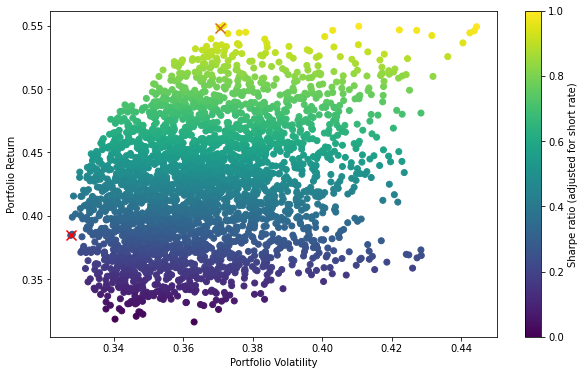

In [18]:
plt.figure(figsize = (10,6))
plt.scatter(port_vols,port_returns,c = (port_returns -r / port_vols), marker='o')
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.scatter(port_vols.min(), port_returns[idx1], c='red', marker = 'x', s=100) # red cross
plt.scatter(port_vols[idx2], port_returns[idx2], c='chocolate', marker = 'x', s=100) # pink cross
plt.colorbar(label = 'Sharpe ratio (adjusted for short rate)')